{0: [1, 3, 4, 6, 8, 10, 12, 14, 16, 17, 19, 21, 22, 24, 25, 27, 29, 31, 32, 34, 36, 38], 1: [2, 7, 15, 18, 23, 28, 35], 5: [0], 4: [5], 2: [9, 13, 20, 30, 37], 3: [11, 26, 33]}


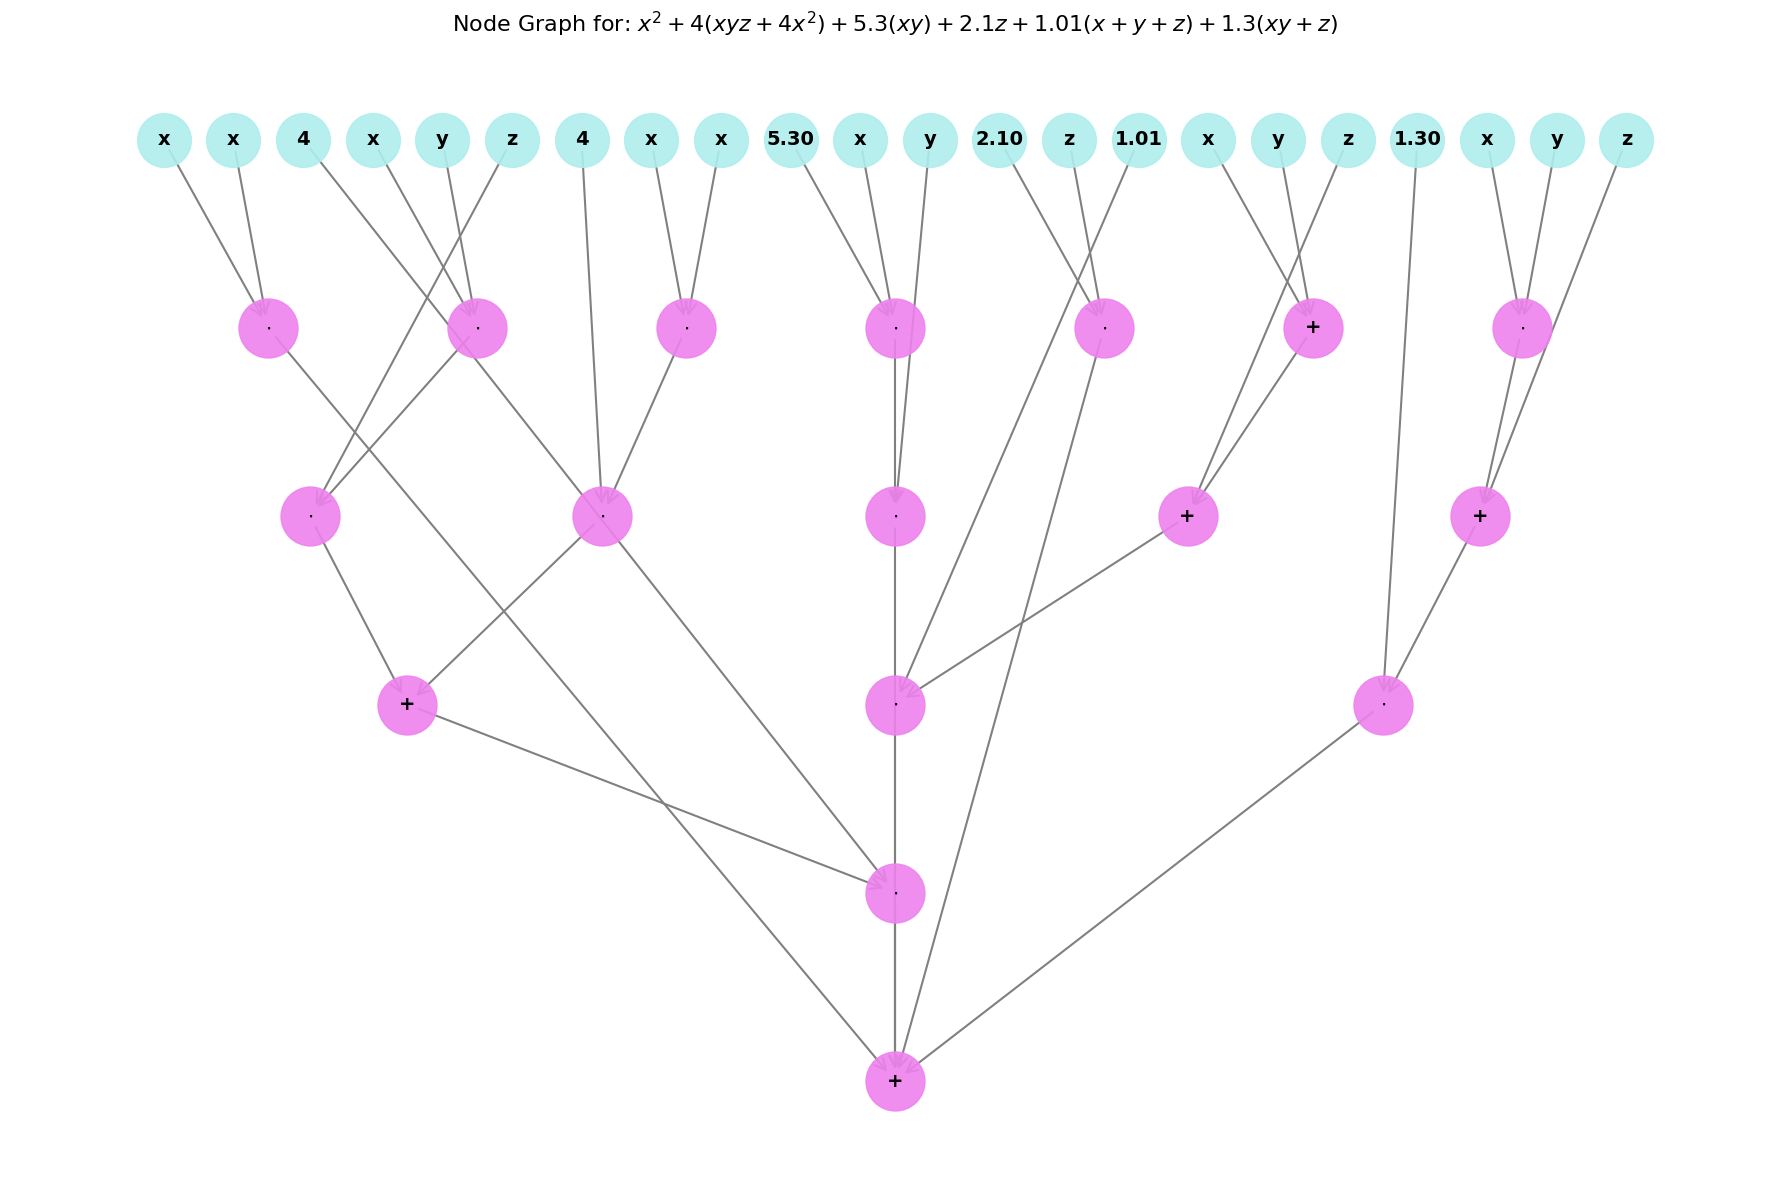

In [109]:
import sympy as sp
import networkx as nx
import matplotlib.pyplot as plt
from sympy.parsing.sympy_parser import parse_expr
from collections import deque, defaultdict
import numpy as np


# Parse a sympy expression and build a node graph showing operations
def create_node_graph(expr):
    graph = nx.DiGraph()
    node_id = 0
    node_id, root_id = process_expression(expr, graph, node_id)
    return graph, root_id


# Process the expression recursively
def process_expression(expr, graph, node_id, parent_id=None, top_level = True):
    if isinstance(expr, sp.Add) or isinstance(expr, sp.Mul):
        args = list(expr.args)

        if top_level:
            #Non binary addition as the last addition in the sequence of polynomials
            add_node = node_id
            graph.add_node(add_node, label="+", type="operation")
            node_id += 1

            for term in args:
                node_id, child_id = process_expression(term, graph, node_id, top_level=False)
                graph.add_edge(child_id, add_node)

            if parent_id is not None:
                graph.add_edge(add_node, parent_id)

            return node_id, add_node

        else:
            label = "+" if isinstance(expr, sp.Add) else r"$\cdot$"
            #Creates a binary tree
            left_expr = args[0]
            node_id, left_id = process_expression(left_expr, graph, node_id, top_level=False)
    
            for expr_branch in args[1:]:
                parent_node = node_id
                graph.add_node(parent_node, label=label, type="operation")
                node_id += 1
    
                # Connect to the parent node
                if parent_id is not None:
                    graph.add_edge(parent_node, parent_id)
                    parent_id = parent_node 
    
                # Left branch
                graph.add_edge(left_id, parent_node)
    
                # Right branch
                node_id, right_id = process_expression(expr_branch, graph, node_id, top_level=False)
                graph.add_edge(right_id, parent_node)
    
                left_id = parent_node  # for chaining
    
            return node_id, left_id

    elif isinstance(expr, sp.Pow):
        base, exp = expr.args
        #Assumes that exponent is an integer
        if exp.is_Integer and exp > 1:
            #Creates a binary tree
            node_id, left_id = process_expression(base, graph, node_id, top_level=False)
            for _ in range(exp - 1):
                mul_node = node_id
                graph.add_node(mul_node, label=r"$\cdot$", type="operation")
                node_id += 1

                node_id, right_id = process_expression(base, graph, node_id, top_level=False)

                graph.add_edge(left_id, mul_node)
                graph.add_edge(right_id, mul_node)

                left_id = mul_node

            if parent_id is not None:
                graph.add_edge(left_id, parent_id)

            return node_id, left_id


    elif isinstance(expr, sp.Symbol):
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id

    elif expr.is_number:
        curr_id = node_id
        graph.add_node(curr_id, label=str(round(expr,2)), type="value")
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id


def node_levels(G, root):
    rev_G = G.reverse()
    
    levels = {root: 0}
    queue = [root]
    while queue:
        node = queue.pop(0)
        for neighbor in rev_G.neighbors(node):
            if neighbor not in levels:
                levels[neighbor] = levels[node] + 1
                queue.append(neighbor)
    
    # Group nodes by level
    nodes_by_level = {}
    for node, level in levels.items():
        if level not in nodes_by_level:
            nodes_by_level[level] = []
        nodes_by_level[level].append(node)
    return nodes_by_level

# Orders nodes based on stages starting from the symbolic characters
def stage_levels(G, node):
    levels = {}
    for node in G.nodes():
        queue = [node]
        layer = 0
    
        #Nodes that have nothing pointing to them, set level to 0
        in_degree = G.in_degree(node)
    
        if in_degree == 0:
            levels[node] = layer
            layer += 1
        
            #Connected nodes have layer one higher
            while queue:
                for i in list(G.successors(queue.pop())):
                    if i in levels.keys():
                        if levels[i] < layer:
                            levels[i] = layer
                    else:
                        levels[i] = layer
                    
                    queue.append(i)
                    layer += 1

    nodes_by_level = {}
    
    for node, level in levels.items():
        if level not in nodes_by_level:
            nodes_by_level[level] = []
        nodes_by_level[level].append(node)
        
    return nodes_by_level


def custom_layout(G, root):
    pos = {}
    #nodes_by_level = node_levels(G, root)
    nodes_by_level = stage_levels(G, root)
    print(nodes_by_level)
    
    for level in nodes_by_level:
        nodes_by_level[level].sort(key=lambda n: (G.nodes[n].get('type', ''), G.nodes[n].get('label', '')))
    
    max_level = max(nodes_by_level)
    spacing = 2 
    
    for level, nodes in nodes_by_level.items():
        num_nodes = len(nodes)
        
        if level == 0:
            max_span = (num_nodes - 1) * spacing    
            x_start = -max_span / 2
            for i, node in enumerate(sorted(nodes)):
                x = x_start + i * spacing
                y = max_level - level
                pos[node] = (x, y)
                
        else:
            if(num_nodes == 1):
                x_start = 0
            else:
                span = (num_nodes - 1) * (max_span/num_nodes)
                x_start = - span/ 2
                
            for i, node in enumerate(sorted(nodes)):
                x = x_start + i * (max_span/num_nodes)
                y = max_level - level
                pos[node] = (x, y)      
    return pos
    
    

def visualize_polynomial(polynomial_str):
    # Parse the expression
    expr = parse_expr(polynomial_str, evaluate=False)
    graph, root_id = create_node_graph(expr)
    node_labels = nx.get_node_attributes(graph, 'label')
    pos = custom_layout(graph, root_id)
    #pos = level_layout(graph, root_id)
    
    plt.figure(figsize=(18, 12))
    
    #Divide up the nodes
    operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
    value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']

    
    nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, 
                        node_size=1800, node_color='violet', alpha=0.9)
    
    nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes,
                        node_size=1500, node_color='paleturquoise', alpha=0.9)
    
    nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', 
                          arrowsize=20, width=1.5, edge_color='gray')
    
    node_id_labels = {node: str(node) for node in graph.nodes()}
    #nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
    nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')
    
    plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show() 

    return graph


#user_input = input("\nEnter a polynomial: ")
user_input = "x^2 + 4*(x*y*z + 4*x^2) + 5.3*(x*y) + 2.1*z + 1.01*(x+y+z) + 1.3*(x*y+z)"

if user_input.strip():
    user_input = user_input.replace('^', '**')
    G = visualize_polynomial(user_input)
